# Semantic Search

## The Task
The objective of this assignment is to engineer a novel wikipedia search engine using what you've learned about data collection, infrastructure, and natural language processing.

The task has two **required sections:**
- Data collection
- Search algorithm development

And one **optional section:** 
  - Predictive modeling

![](http://interactive.blockdiag.com/image?compression=deflate&encoding=base64&src=eJxdjrsOwjAMRXe-wlsmRhaQkDoiMSDxBW5slahtHDmGCiH-nfQxtKy-59zruhPfUsAGPjsA56XvMdIRSIbYCZKD_RncENqQuGBQ3S7TidCwxsynjZUZ1T8m4HqvJlXZnhrBJMHBbWlTDHEeSFravYUXQy_E3TKrwbioMKb5z16UmRxfXZurVY_GjegbhqJIjaXm-wNmzE4W)

### Part 1 -- Collection (required)

We want you to query the wikipedia API and **collect all of the articles** under the following wikipedia categories:

* [Machine Learning](https://en.wikipedia.org/wiki/Category:Machine_learning)
* [Business Software](https://en.wikipedia.org/wiki/Category:Business_software)

The raw page text and its category information should be written to a collection on a Mongo server running on a dedicated AWS instance.

We want your code to be modular enough that any valid category from Wikipedia can be queried by your code. You are encouraged to exploit this modularity to pull additional wikipedia categories beyond ML and Business Software. As always, the more data the better. 

**Note:** Both "Machine Learning" and "Business Software" contain a heirarchy of nested sub-categories. Make sure that you pull every single page within each parent category, not just those directly beneath them. Take time to explore wikipedia's organization structure. It is up to you if you want to model this heirarchy anywhere within Mongo, otherwise flatten it by only recording the parent category associated with each page.

In [2]:
# cd to directory above to access sub-directories.
%cd ..

/home/jovyan/GA_DSI/Projects/project_4/semantic_search


In [3]:
%ls

data/  ipynb/  lib/  ProjectFlow.ipynb  README.md


In [3]:
#!pip install pymongo

In [96]:
# Import my functions from 
import lib.wiki_utilities as wiki
import lib.mongo_utilities as mongo
import lib.general_utilities as gu

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.core.display import display, HTML

%matplotlib inline

In [39]:
# read pickled 'Machine Learning' category collection of pages and contents.
ML_clean_collection_lst = gu.read_pickle_obj('data/wiki_ML_cleantext_pages_lst.obj')

# read pickled 'Business Software' category collection of pages and contents.
BS_clean_collection_lst = gu.read_pickle_obj('data/wiki_BS_cleantext_pages_lst.obj')

In [41]:
# put ML and BS collections in dataframes.
ML_collection_df = pd.DataFrame(ML_clean_collection_lst)
BS_collection_df = pd.DataFrame(BS_clean_collection_lst)

In [14]:
ML_collection_df.head(4)

,_id,pageid,text,title
0,5a0ee924b1ec8c044b037a47,43385931,Data exploration is an approach similar to ini...,Data exploration
1,5a0ee924b1ec8c044b037a48,49082762,These datasets are used for machine-learning r...,List of datasets for machine learning research
2,5a0ee924b1ec8c044b037a49,233488,Machine learning is a field of computer scienc...,Machine learning
3,5a0ee924b1ec8c044b037a4a,53587467,The following outline is provided as an overvi...,Outline of machine learning


In [9]:
# size of ML collection.
ML_collection_df.shape

(1104, 4)

In [42]:
# drop the '_id' category. 
ML_collection_df.drop('_id', axis=1, inplace=True)

In [15]:
ML_collection_df.head(1)

,_id,pageid,text,title
0,5a0ee924b1ec8c044b037a47,43385931,Data exploration is an approach similar to ini...,Data exploration


In [16]:
# Look at the page.
ML_collection_df.text[0][:500]

'Data exploration is an approach similar to initial data analysis, whereby a data analyst uses visual exploration to understand what is in a dataset and the characteristics of the data, rather than through traditional data management systems. These characteristics can include size or amount of data, completeness of the data, correctness of the data, possible relationships amongst data elements or files/tables in the data.Data exploration is typically conducted using a combination of automated and'

In [12]:
# size of BS collection.
BS_collection_df.shape

(3020, 4)

In [13]:
BS_collection_df.head(4)

,_id,pageid,text,title
0,5a10ca31b1ec8c010121baa5,1037763,Business software or a business application is...,Business software
1,5a10ca31b1ec8c010121baa6,41270069,AccuSystems LLC is an American company headqua...,AccuSystems
2,5a10ca31b1ec8c010121baa7,5211212,Active policy management is business-oriented ...,Active policy management
3,5a10ca31b1ec8c010121baa8,28502793,Alexandria is browser based cross-platform lib...,Alexandria (library software)


In [43]:
# drop the '_id' category. 
BS_collection_df.drop('_id', axis=1, inplace=True)

In [15]:
BS_collection_df.head(1)

,pageid,text,title
0,1037763,Business software or a business application is...,Business software


In [13]:
# Look at the page.
BS_collection_df.text[0][:500]

'Business software or a business application is any software or set of computer programs used by business users to perform various business functions. These business applications are used to increase productivity, to measure productivity and to perform other business functions accurately.By and large, business software is likely to be developed to meet the needs of a specific business, and therefore is not easily transferable to a different business environment, unless its nature and operation is'

In [44]:
# make one dataframe with the ML and BS data.
BS_ML_collection_df = pd.DataFrame(ML_clean_collection_lst + BS_clean_collection_lst)

In [45]:
# drop the '_id' category. 
BS_ML_collection_df.drop('_id', axis=1, inplace=True)

In [46]:
# pickle the aggregate dataframe.
gu.pickle_obj('data/BS_ML_collection_df.obj', BS_ML_collection_df)

In [47]:
# read the aggregate collection dataframe. 
BS_ML_collection_df = gu.read_pickle_obj('data/BS_ML_collection_df.obj')

In [48]:
# size of the aggregate corpus, with content from ML and BS pages.
BS_ML_collection_df.shape

(4124, 3)

**Latent semantic analysis (LSA)** is a technique in natural language processing, in particular distributional semantics, of analyzing relationships between a set of documents and the terms they contain by producing a set of concepts related to the documents and terms. LSA assumes that words that are close in meaning will occur in similar pieces of text (the distributional hypothesis). A matrix containing word counts per paragraph (rows represent unique words and columns represent each paragraph) is constructed from a large piece of text and a mathematical technique called singular value decomposition (SVD) is used to reduce the number of rows while preserving the similarity structure among columns. Words are then compared by taking the cosine of the angle between the two vectors (or the dot product between the normalizations of the two vectors) formed by any two rows. Values close to 1 represent very similar words while values close to 0 represent very dissimilar words.

In [26]:
#************** Latent Semantic Analysis = Document Term Matrix + SVD *******************

In [27]:
# TFIDF text encoder.
tfidf_vectorizer = TfidfVectorizer(min_df = 1, stop_words = 'english')

In [28]:
# TFIDF encode the corpus of documents.
# A matrix containing word counts per page.
document_term_matrix = tfidf_vectorizer.fit_transform(BS_ML_collection_df['text'])

In [81]:
# pickle document_term_matrix and tfidf transformer.
gu.pickle_obj('data/tfidf_vectorizer_fit_transformed.obj', tfidf_vectorizer)
gu.pickle_obj('data/document_term_matrix.obj', document_term_matrix)

In [5]:
# read pickled document_term_matrix and tfidf transformer.
tfidf_vectorizer = gu.read_pickle_obj('data/tfidf_vectorizer_fit_transformed.obj')
document_term_matrix = gu.read_pickle_obj('data/document_term_matrix.obj')

In [30]:
# singular value decomposition (SVD)
# a mathematical technique called  is used to reduce the number of rows
# while preserving the similarity structure among columns.
SVD = TruncatedSVD(500)

In [31]:
# SVD fit and transform the corpus data.
SVD_corpus = SVD.fit_transform(document_term_matrix)

In [19]:
# pickle SVD transformer and the SVD transformed corpus.
gu.pickle_obj('data/SVD_500_fit_transformed.obj', SVD)
gu.pickle_obj('data/SVD_corpus.obj', SVD_corpus)

In [6]:
# read pickled SVD transformed corpus and SVD transformer.
SVD = gu.read_pickle_obj('data/SVD_500_fit_transformed.obj')
SVD_corpus = gu.read_pickle_obj('data/SVD_corpus.obj')

In [21]:
sum(SVD.explained_variance_ratio_)

0.36871328044038826

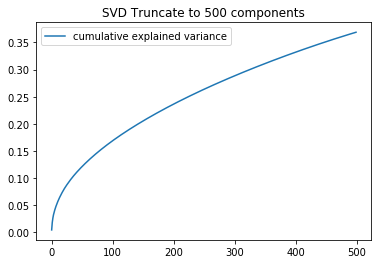

In [22]:
plt.plot(range(500), np.cumsum(SVD.explained_variance_ratio_), label='cumulative explained variance')
plt.title('SVD Truncate to 500 components')
plt.legend()

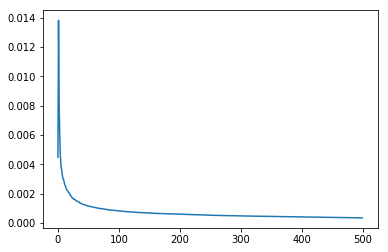

In [34]:
plt.plot(SVD.explained_variance_ratio_)

In [ ]:
# take a query and TFIDF transform then SVD transform.
# should have transformed my query text into a 500 dimensional 
# vector (500 cols) then calculate the similarity of this transformed 
# query to the transfomed corpus.

In [7]:
query = "stochastic time-series forecasting"

In [8]:
# encode query, svd query, calculate the cosine simiarity of query to
# the corpus data.
tf_query = tfidf_vectorizer.transform([query])
svd_query = SVD.transform(tf_query)
cosine_sim_query_to_corpus = cosine_similarity(SVD_corpus, svd_query)

In [9]:
cosine_sim_query_to_corpus[:5]

array([[ 0.00486655],
       [-0.003097  ],
       [ 0.01917968],
       [ 0.05214104],
       [ 0.0078121 ]])

In [13]:
# find top 5 best matches.
ind = cosine_sim_query_to_corpus.argsort(axis = 0)[::-1]

top5_pages = [ind[i][0] for i in range(5)]
top5_pages

[814, 336, 902, 934, 935]

In [53]:
# data for top 5 pages that best match the user query.
selected_pgs_df = BS_ML_collection_df.loc[top5_pages, :]
selected_pgs_df

,pageid,text,title
814,16369738,"In statistics, a doubly stochastic model is a ...",Doubly stochastic model
336,2070605,Stochastic neural networks are a type of artif...,Stochastic neural network
902,11071463,"In the mathematical theory of probability, the...",Entropy rate
934,39033720,Stochastic cellular automata or 'probabilistic...,Stochastic cellular automaton
935,217313,"""Transition matrix"" redirects here. For ""trans...",Stochastic matrix


In [55]:
page_titles = selected_pgs_df.title.values

page_titles

array(['Doubly stochastic model', 'Stochastic neural network',
       'Entropy rate', 'Stochastic cellular automaton', 'Stochastic matrix'], dtype=object)

In [101]:
query = input("Enter your wiki query: ")

# encode query, svd query, calculate the cosine simiarity of query to
# the corpus data
tf_query = tfidf_vectorizer.transform([query])
svd_query = SVD.transform(tf_query)
cosine_sim_query_to_corpus = cosine_similarity(SVD_corpus, svd_query)

# find the top 5 most similar pages for the query.
ind = cosine_sim_query_to_corpus.argsort(axis = 0)[::-1]
top5_pages = [ind[i][0] for i in range(5)]
selected_pgs_df = BS_ML_collection_df.loc[top5_pages, :]
page_titles = selected_pgs_df.title.values

# display top 5 pages for the query, as weblinks.
print("\nHere are the top 5 wiki page links for your query: ")

for pg_title in page_titles:
    pg_title_no_sp = pg_title.replace(' ', '_')
    
    url=("<a href='https://www.wikipedia.org/wiki/" +
         pg_title_no_sp +
         "' target='_blank'>" +
         pg_title +
         "</a>")

    display(HTML(url))

Enter your wiki query: stochastic time-series forecasting

Here are the top 5 wiki page links for query: stochastic time-series forecasting
